## Machine Learning with Keras on Amazon's fine food review

This notebook will create a convolutional neural network (CNN) off of the fine food review to suggest if the review is a positive (4 or 5 star rating) or a non-positive (1, 2, or 3 star rating).  What we aim here is to use the word2vec embedding implementation in Keras to convert the text into word vectors, and train a CNN with it.

In [49]:
#data importing/wrangling
import pandas as pd

#text processing 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#CNN modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding


#data split
from sklearn.model_selection import train_test_split

#vizualization
import matplotlib.pyplot as plt
import numpy as np


input_location = '/Users/momori/Downloads/amazon-fine-food-reviews/reviews_processed.csv'

In [8]:
data = pd.read_csv(input_location)

In [9]:
data.columns

Index([u'Unnamed: 0', u'Id', u'ProductId', u'UserId', u'ProfileName',
       u'HelpfulnessNumerator', u'HelpfulnessDenominator', u'Score', u'Time',
       u'Summary', u'Text', u'HelpfulnessRatio'],
      dtype='object')

In [91]:
#add a positive/non-positive rating oolumn
data['positive_review'] = data['Score'] > 3

In [93]:
#separate out the documents from the data
docs = data['Text']
labels = data['positive_review']

## Word2Vec embedding



In [20]:
#Word2Vec embedding

#use the tokenizer API provided by Keras to turn documents into sequences
t = Tokenizer()
t.fit_on_texts(docs)

#encode the documents into integers
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs[0])

[2, 17, 125, 319, 7, 1, 4940, 523, 103, 52, 204, 3, 17, 117, 28, 41, 5, 30, 7, 29, 183, 1, 38, 629, 48, 26, 4, 2636, 58, 4, 1183, 448, 3, 6, 619, 99, 13, 5266, 8, 1777, 3, 94, 8695, 9, 38, 99, 58, 140]


In [52]:
#create a list of lengths of each of the encoded_docs to find out the longest length, 
#and see if any 0 padding is required

length_docs = []
for doc in encoded_docs:
    for i in doc:
        length_docs.append(i)

#find max length
print(max(length_docs))

133038


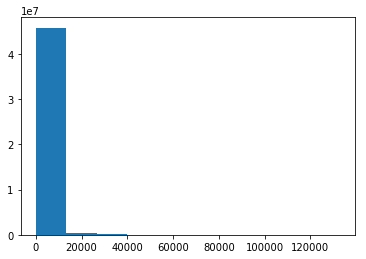

In [54]:
#let's put the lengths into a histogram to see the distributions of the lengths
plt.hist(length_docs)
plt.show()


In [55]:
#check the percentiles of lengths
np_array = np.array(length_docs)

for i in [50,60,70,80,90,99]:
    print i, " percentile of document length:", np.percentile(np_array,i)

50  percentile of document length: 78.0
60  percentile of document length: 159.0
70  percentile of document length: 322.0
80  percentile of document length: 697.0
90  percentile of document length: 1943.0
99  percentile of document length: 18360.0


We can see that most of the documents has length less than 1943. Let's zoom in here and see the distribution at a more granular level.

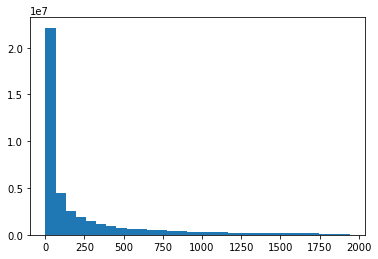

In [56]:
#let's put the lengths into a histogram to see the distributions of the lengths
plt.hist([x for x in length_docs if x <= 1943], bins=30)
plt.show()



Let's cap the maximum length of the reviews to 1943 words, as that will give us a good sense of the overall data without having to zero pad the short reviews to match really big reviews.  

In [57]:
#zero pad the shorter texts
max_length = 1943
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [81]:
#find largest vocabulary index (vocabulary size)
l_max = 0
for doc in padded_docs:
    for i in doc:
         if i > l_max:
                l_max = i
print l_max

133038


## Modeling
now that we have the data, we can split this into train/test and create a CNN using Keras.


In [101]:
#split the data
train_size = 0.7

x_train, x_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=train_size, random_state=42)

In [102]:
#create the CNN
vect_dimension = 8

model = Sequential()
model.add(Embedding(l_max+1, vect_dimension, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

#model compilation. add loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# check model
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1943, 8)           1064312   
_________________________________________________________________
flatten_13 (Flatten)         (None, 15544)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 15545     
Total params: 1,079,857
Trainable params: 1,079,857
Non-trainable params: 0
_________________________________________________________________
None


In [106]:
# fit the model
model.fit(x_train, y_train, epochs=2, verbose=1)

# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
170535/170535 [==============================] - 97s - loss: 0.1297 - acc: 0.9531    - ETA: 1s - lo
Epoch 2/2
169824/170535 [============================>.] - ETA: 0sAccuracy: 97.753540


In [107]:
#put on test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

397917/397917 [==============================] - 14s    
Accuracy: 90.531191
